# Forest cover type prediction

This is a multiclass classification problem that given a set of cartographic-only features, we are to predict the cover type of 30x30 m patches in 4 forest areas in Colorado.

The 7 category types:
- Spruce/Fir
- Lodgepole Pine
- Ponderosa Pine
- Cottonwood/Willow
- Aspen
- Douglas-fir
- Krummholz

Accuracy as the evaluation metric

## Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!ls inputs/

test.csv
test3.csv
train.csv


In [3]:
train_df = pd.read_csv("./inputs/train.csv")
test_df = pd.read_csv("./inputs/test.csv")
test3_df = pd.read_csv("./inputs/test3.csv")

print("train_df.shape, test_df.shape, test3_df.shape")
train_df.shape, test_df.shape, test3_df.shape

train_df.shape, test_df.shape, test3_df.shape


((15120, 56), (565892, 55), (5, 5))

In [4]:
# This is clearly some error, and will be ignored....
test3_df

id    fruit   count   drinks      snacks
0   1    apple       2        4    hersheys
1   2   banana       3        3   ice cream
2   3   citrus       4        1     cookies
3   4    apple       3        3      donuts
4   5   durian       5        6      icepop

In [5]:
# train_df contains the predicted variable Cover_Type, which test_df does not have
set(train_df.columns) - set(test_df.columns)

{'Cover_Type'}

## Data quality check
Test for nulls, dtypes and if everything fits

First let's start to check for nulls in the predicted variable, ideally it should be zero

In [6]:
print("Cover_Type column")
print("# of nulls: ",train_df["Cover_Type"].isnull().sum())
print("# of unique values: ",train_df["Cover_Type"].nunique())
print("unique values",train_df["Cover_Type"].unique())

Cover_Type column
# of nulls:  0
# of unique values:  7
unique values [5 2 1 7 3 6 4]


In [7]:
train_df["Cover_Type"].value_counts()

5    2160
2    2160
1    2160
7    2160
3    2160
6    2160
4    2160
Name: Cover_Type, dtype: int64

Now let's check for data quality overall

In [8]:
combine = [train_df, test_df]

In [9]:
predictors = train_df.drop(["Id","Cover_Type"],axis=1).columns
predictors

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

No null values were found, which is interesting

In [10]:
print("Predictors with null values in train and test dataset")
for df in combine:
    null_count = []
    
    for p in predictors.values:
        count = df[p].isna().sum()
        if count == 0:
            continue
        null_count.append((p,))
        
    print(null_count,"\n")

Predictors with null values in train and test dataset
[] 

[] 



### Group predictors by type

In [11]:
soil_type_predictors = []

for p in predictors.values:
    if not p.startswith("Soil_Type"):
        continue
    soil_type_predictors.append(p)
    
print(soil_type_predictors)

['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


In [12]:
distance_predictors = [
    'Elevation',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points']

In [13]:
hillshade_predictors = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

In [14]:
degrees_predictors = ['Aspect', 'Slope']

In [15]:
area_predictors = [
    'Wilderness_Area1',
    'Wilderness_Area2',
    'Wilderness_Area3', 
    'Wilderness_Area4']

### Degrees Predictors
- Slope distribution looks like a bell-shaped skewed distribution on train set
- Slope distribution in test set is much more concentrated in few similar measurements
- Aspect azimuth 360 degrees angle makes distribution with 2 peaks and a valley, conversion may make look like a bell-shaped curve

Train


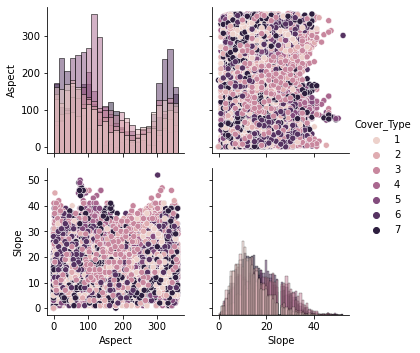

In [66]:
print("Train")
g = sns.PairGrid(train_df[degrees_predictors+["Cover_Type"]],hue="Cover_Type")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

Test


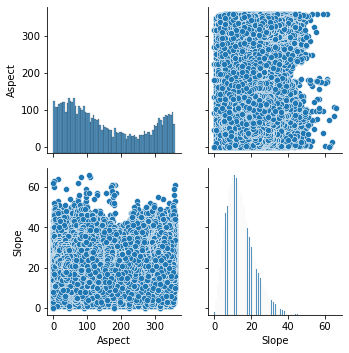

In [68]:
print("Test")
g = sns.PairGrid(test_df[degrees_predictors])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

### Distance predictors
- Slight correlation between Vertical and Horizontal distance to Hydrology
- Elevation distribution differs between train and test data

#### Actions
- None

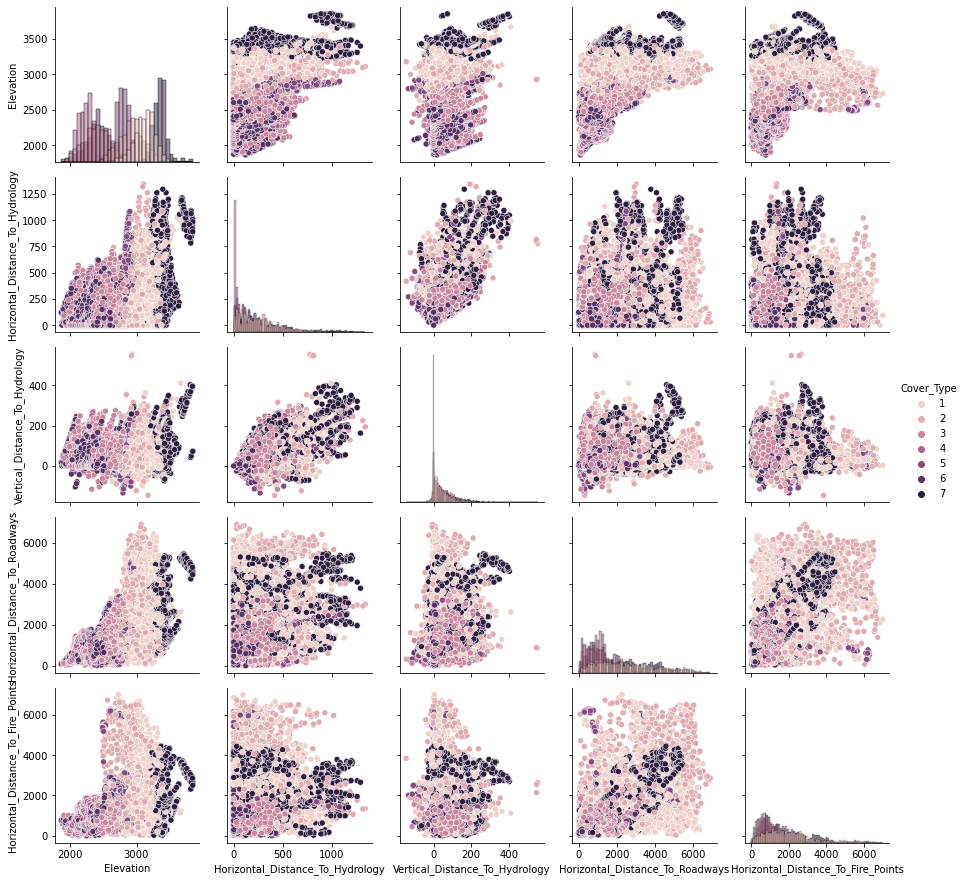

In [69]:
g = sns.PairGrid(train_df[distance_predictors+["Cover_Type"]],hue="Cover_Type")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

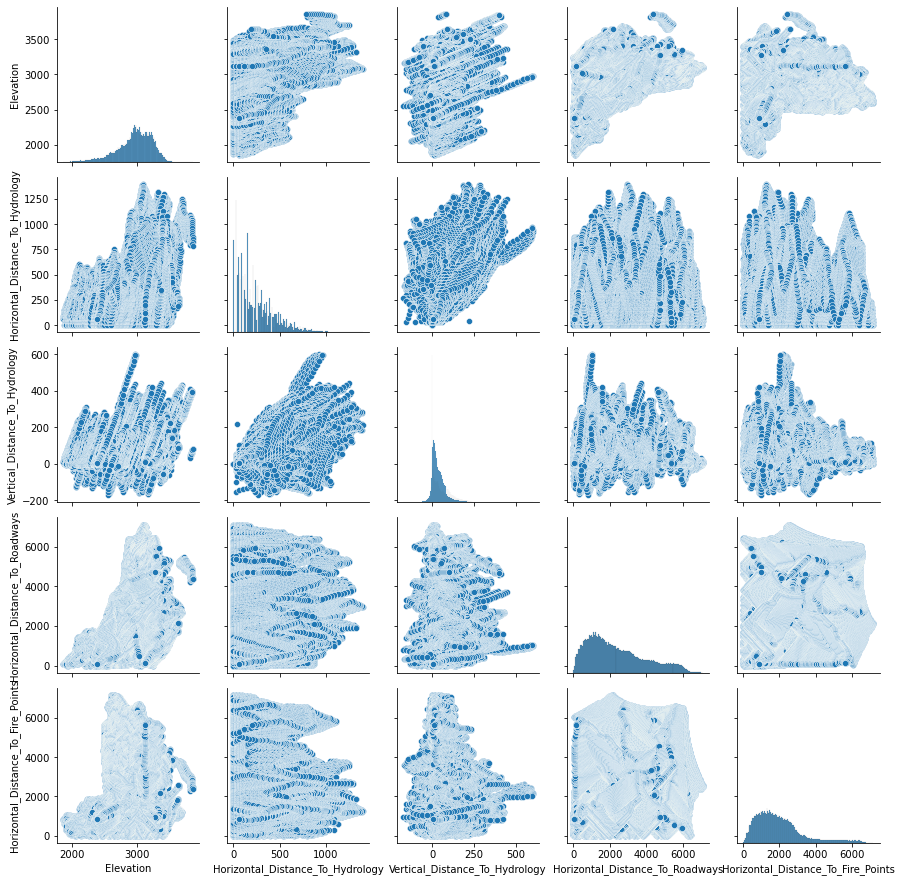

In [19]:
g = sns.PairGrid(test_df[distance_predictors])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

### Hillshade predictors

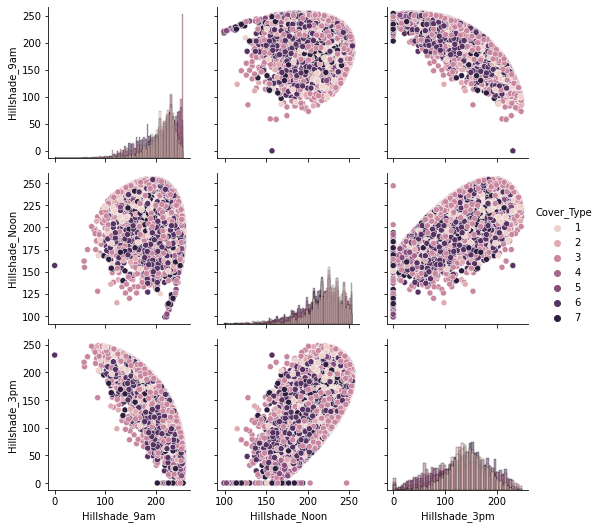

In [70]:
g = sns.PairGrid(train_df[hillshade_predictors+["Cover_Type"]],hue="Cover_Type")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

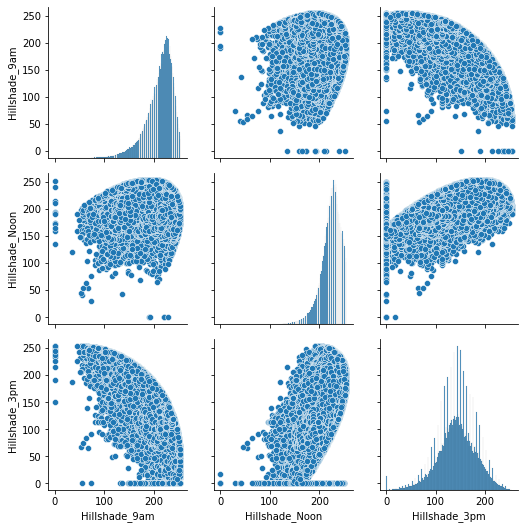

In [71]:
g = sns.PairGrid(test_df[hillshade_predictors])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

### Area predictors
- Train test has an unbalanced distribution of samples, while Test set has a balanced distribution of samples around areas
- Lack of Area 2 samples can be a challenge in model accuracy

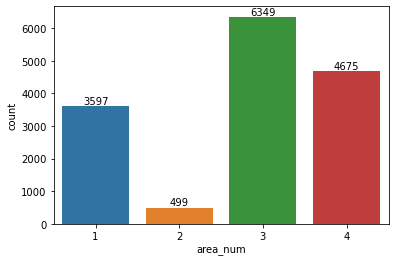

In [20]:
df_train_areas = pd.melt(train_df[area_predictors]).rename(columns={"variable": "area","value":"is_on_area"})
df_train_areas["area_num"] = df_train_areas["area"].str[-1:]
ax = sns.countplot(x=df_train_areas.loc[df_train_areas["is_on_area"] == 1,"area_num"])
for i in ax.containers:
    ax.bar_label(i,)

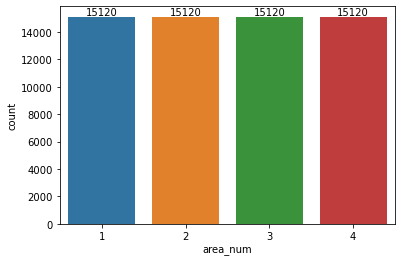

In [21]:
df_test_areas = pd.melt(test_df[area_predictors]).rename(columns={"variable": "area","value":"is_on_area"})
df_test_areas["area_num"] = df_train_areas["area"].str[-1:]
ax = sns.countplot(x=df_test_areas.loc[df_test_areas["is_on_area"] == 1,"area_num"])
for i in ax.containers:
    ax.bar_label(i,)

In [22]:
totals_dict = train_df[["Cover_Type"] + area_predictors].groupby("Cover_Type").sum().sum().to_dict()
# totals_dict = train_df["Cover_Type"].value_counts().to_dict()
cover_type_by_area_abs = (
    train_df[["Cover_Type"] + area_predictors]
    .groupby("Cover_Type").sum()
    .T
    .reset_index()
    .rename(columns={"index":"area"})
)
cover_type_by_area_abs

Cover_Type              area     1     2     3     4     5     6     7
0           Wilderness_Area1  1062  1134     0     0   856     0   545
1           Wilderness_Area2   181    66     0     0     0     0   252
2           Wilderness_Area3   917   940   863     0  1304   962  1363
3           Wilderness_Area4     0    20  1297  2160     0  1198     0

In [23]:
cover_type_by_area_perc = cover_type_by_area_abs.copy()
for col in range(1,8):
    cover_type_by_area_perc[col] = cover_type_by_area_abs.apply(lambda row: row[col]/(totals_dict[row['area']]),axis=1)

In [24]:
round(cover_type_by_area_perc ,2)

Cover_Type              area     1     2     3     4     5     6     7
0           Wilderness_Area1  0.30  0.32  0.00  0.00  0.24  0.00  0.15
1           Wilderness_Area2  0.36  0.13  0.00  0.00  0.00  0.00  0.51
2           Wilderness_Area3  0.14  0.15  0.14  0.00  0.21  0.15  0.21
3           Wilderness_Area4  0.00  0.00  0.28  0.46  0.00  0.26  0.00

## Exploratory Data Analysis - Finding correlations to the predicted class

### Distance predictors
- We can observe that Elevation is probably a good predictor for cover type, as there is little intersection in elevation ranges between types 1, 2, 3, 4, and 7
- Horizontal_Distance_To_Roadways appears to be a good feature to help separate 2 type from 5 type and 3 type from 6 type, as Elevation is similar in both of them
- Other features doesn't seem as strong

#### Actions
- Include Elevation and Horizontal_Distance_To_Roadways as model predictors

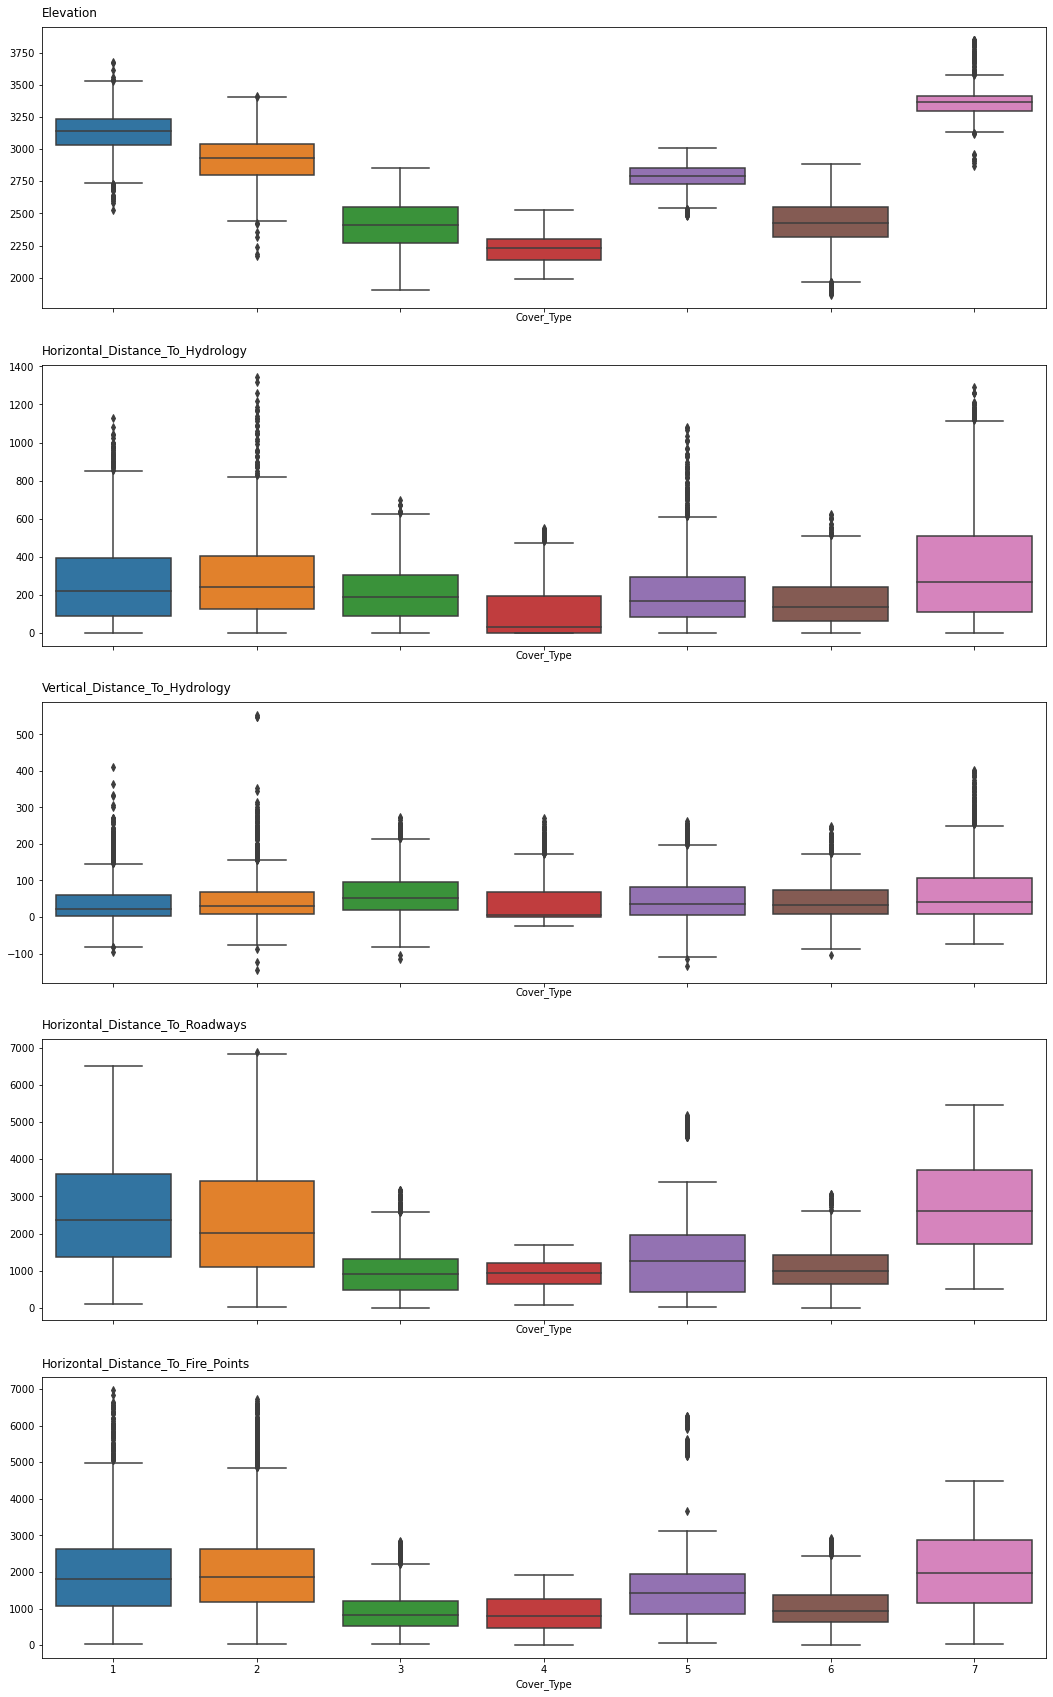

In [48]:
df = train_df[["Cover_Type"] + distance_predictors]
fig, axes = plt.subplots(nrows=len(distance_predictors),sharex='col',figsize=(18,30))

for i in range(0,len(distance_predictors)):
    ax = sns.boxplot(ax=axes[i], data=df,x="Cover_Type", y=distance_predictors[i])
    ax.set_ylabel('')
    ax.set_title(distance_predictors[i],loc='left',pad=10)

### Degrees predictors
- Both Aspect and Slope don't seem like extraordinary predictors, but may be helpful
#### Actions
- Include Aspect and Slope in the model

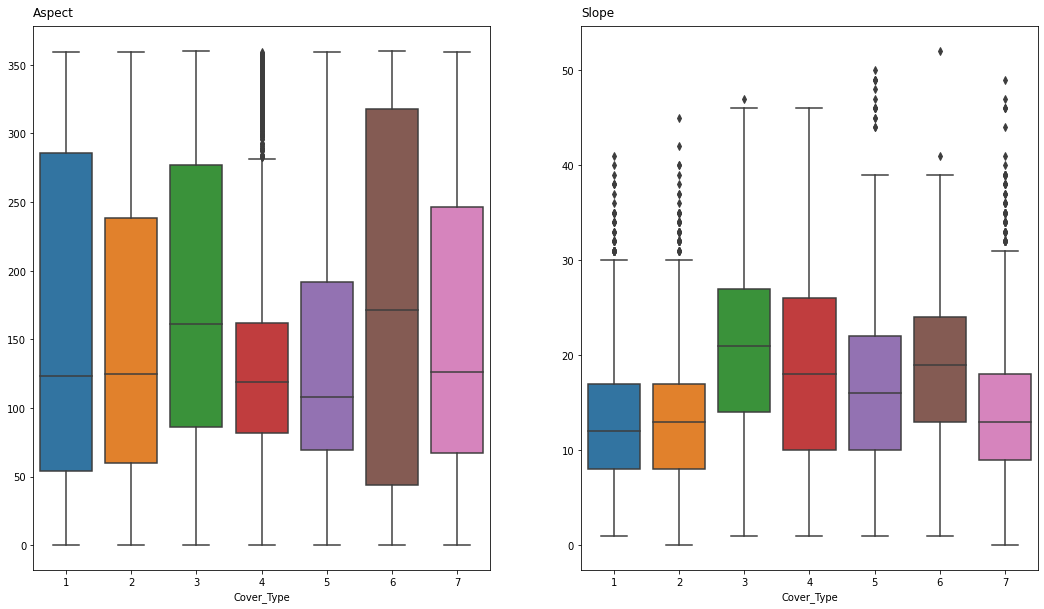

In [50]:
features_subset = degrees_predictors
df = train_df[["Cover_Type"] + features_subset]
fig, axes = plt.subplots(ncols=len(features_subset),sharex='col',figsize=(18,10))

for i in range(0,len(features_subset)):
    ax = sns.boxplot(ax=axes[i], data=df,x="Cover_Type", y=features_subset[i])
    ax.set_ylabel('')
    ax.set_title(features_subset[i],loc='left',pad=10)

<AxesSubplot:xlabel='Cover_Type', ylabel='Aspect_Transformed'>

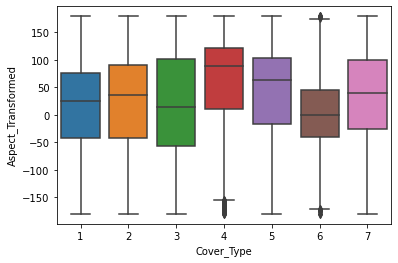

In [61]:
df.loc[:,"Aspect_Transformed"] = df["Aspect"].map(lambda x: (-1)*(360-x) if x >=180 else x)

sns.boxplot(data=df,x="Cover_Type", y="Aspect_Transformed")

### Hillshade predictors

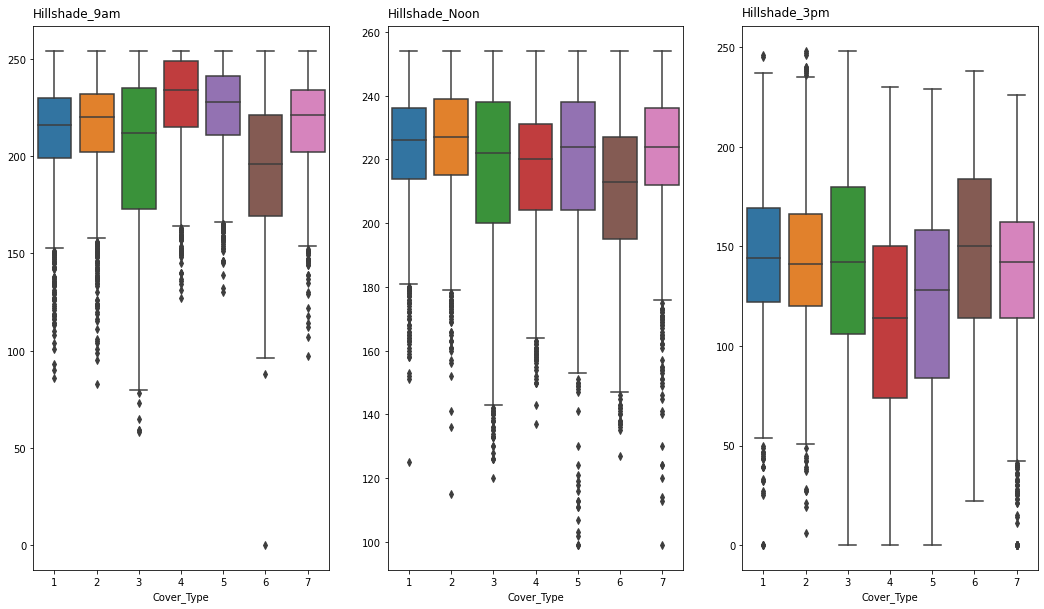

In [62]:
features_subset = hillshade_predictors
df = train_df[["Cover_Type"] + features_subset]
fig, axes = plt.subplots(ncols=len(features_subset),sharex='col',figsize=(18,10))

for i in range(0,len(features_subset)):
    ax = sns.boxplot(ax=axes[i], data=df,x="Cover_Type", y=features_subset[i])
    ax.set_ylabel('')
    ax.set_title(features_subset[i],loc='left',pad=10)

## Choosing some initial models to test

This is a multi-class classification problem, but from the analyzed data and the number of classes we can see that it is probably a non-linear problem.

The best choice would be probably a non-linear classification algorithm such as:
- K-NN
- Non-Linear SVM
- Decision Trees
- Ensemble (Adaboost, XGBoost, 

There are at least 4 different scales for the predictors (binary, 0-255 index, distance (m/Km) and 

In [83]:
for i in range (1,8):
    train_df.loc[:,"Cover_Type" + str(i)] = train_df.loc[:,"Cover_Type"].map(lambda x: x == i) 

In [89]:
lin_viz = (
    train_df[distance_predictors+hillshade_predictors+area_predictors+degrees_predictors+ ["Cover_Type1"]]
    .sample(n=1000, random_state=2023)
)
lin_viz

Elevation  Horizontal_Distance_To_Hydrology  \
3668        2227                               175   
12680       2154                                 0   
8562        2853                               470   
5721        2457                                 0   
2396        2751                                42   
...          ...                               ...   
2446        2832                               162   
10666       2694                               150   
7763        3133                              1112   
12257       2144                               124   
7813        3371                               874   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
3668                              107                             1040   
12680                               0                             1298   
8562                              187                             2192   
5721                                0                              466   
2396                               -5                             1681   
...                               ...                              ...   
2446                               37                             1663   
10666                             -41                              882   
7763                              264                             2809   
12257                             -36                              616   
7813                              121                             1129   

       Horizontal_Distance_To_Fire_Points  Hillshade_9am  Hillshade_Noon  \
3668                                  433            248             202   
12680                                1136            235             240   
8562                                 1986            224             242   
5721                                 1415            240             202   
2396                                 1142            183             251   
...                                   ...            ...             ...   
2446                                 1712            175             208   
10666                                 722            173             249   
7763                                 1707            200             201   
12257                                 547            184             137   
7813                                 1991            196             219   

       Hillshade_3pm  Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  \
3668              50                 0                 0                 0   
12680            133                 0                 0                 0   
8562             132                 0                 0                 1   
5721              84                 0                 0                 0   
2396             204                 0                 0                 1   
...              ...               ...               ...               ...   
2446             170                 0                 0                 1   
10666            193                 0                 0                 1   
7763             134                 0                 0                 1   
12257             63                 0                 0                 0   
7813             162                 0                 0                 1   

       Wilderness_Area4  Aspect  Slope  Cover_Type1  
3668                  1     137     35        False  
12680                 1     152     13        False  
8562                  0     174     27        False  
5721                  1      77     19        False  
2396                  0     247     17        False  
...                 ...     ...    ...          ...  
2446                  0     339     20        False  
10666                 0     214     32        False  
7763                  0      13     18        False  
12257                 1      30     37        False  
7813                  0  

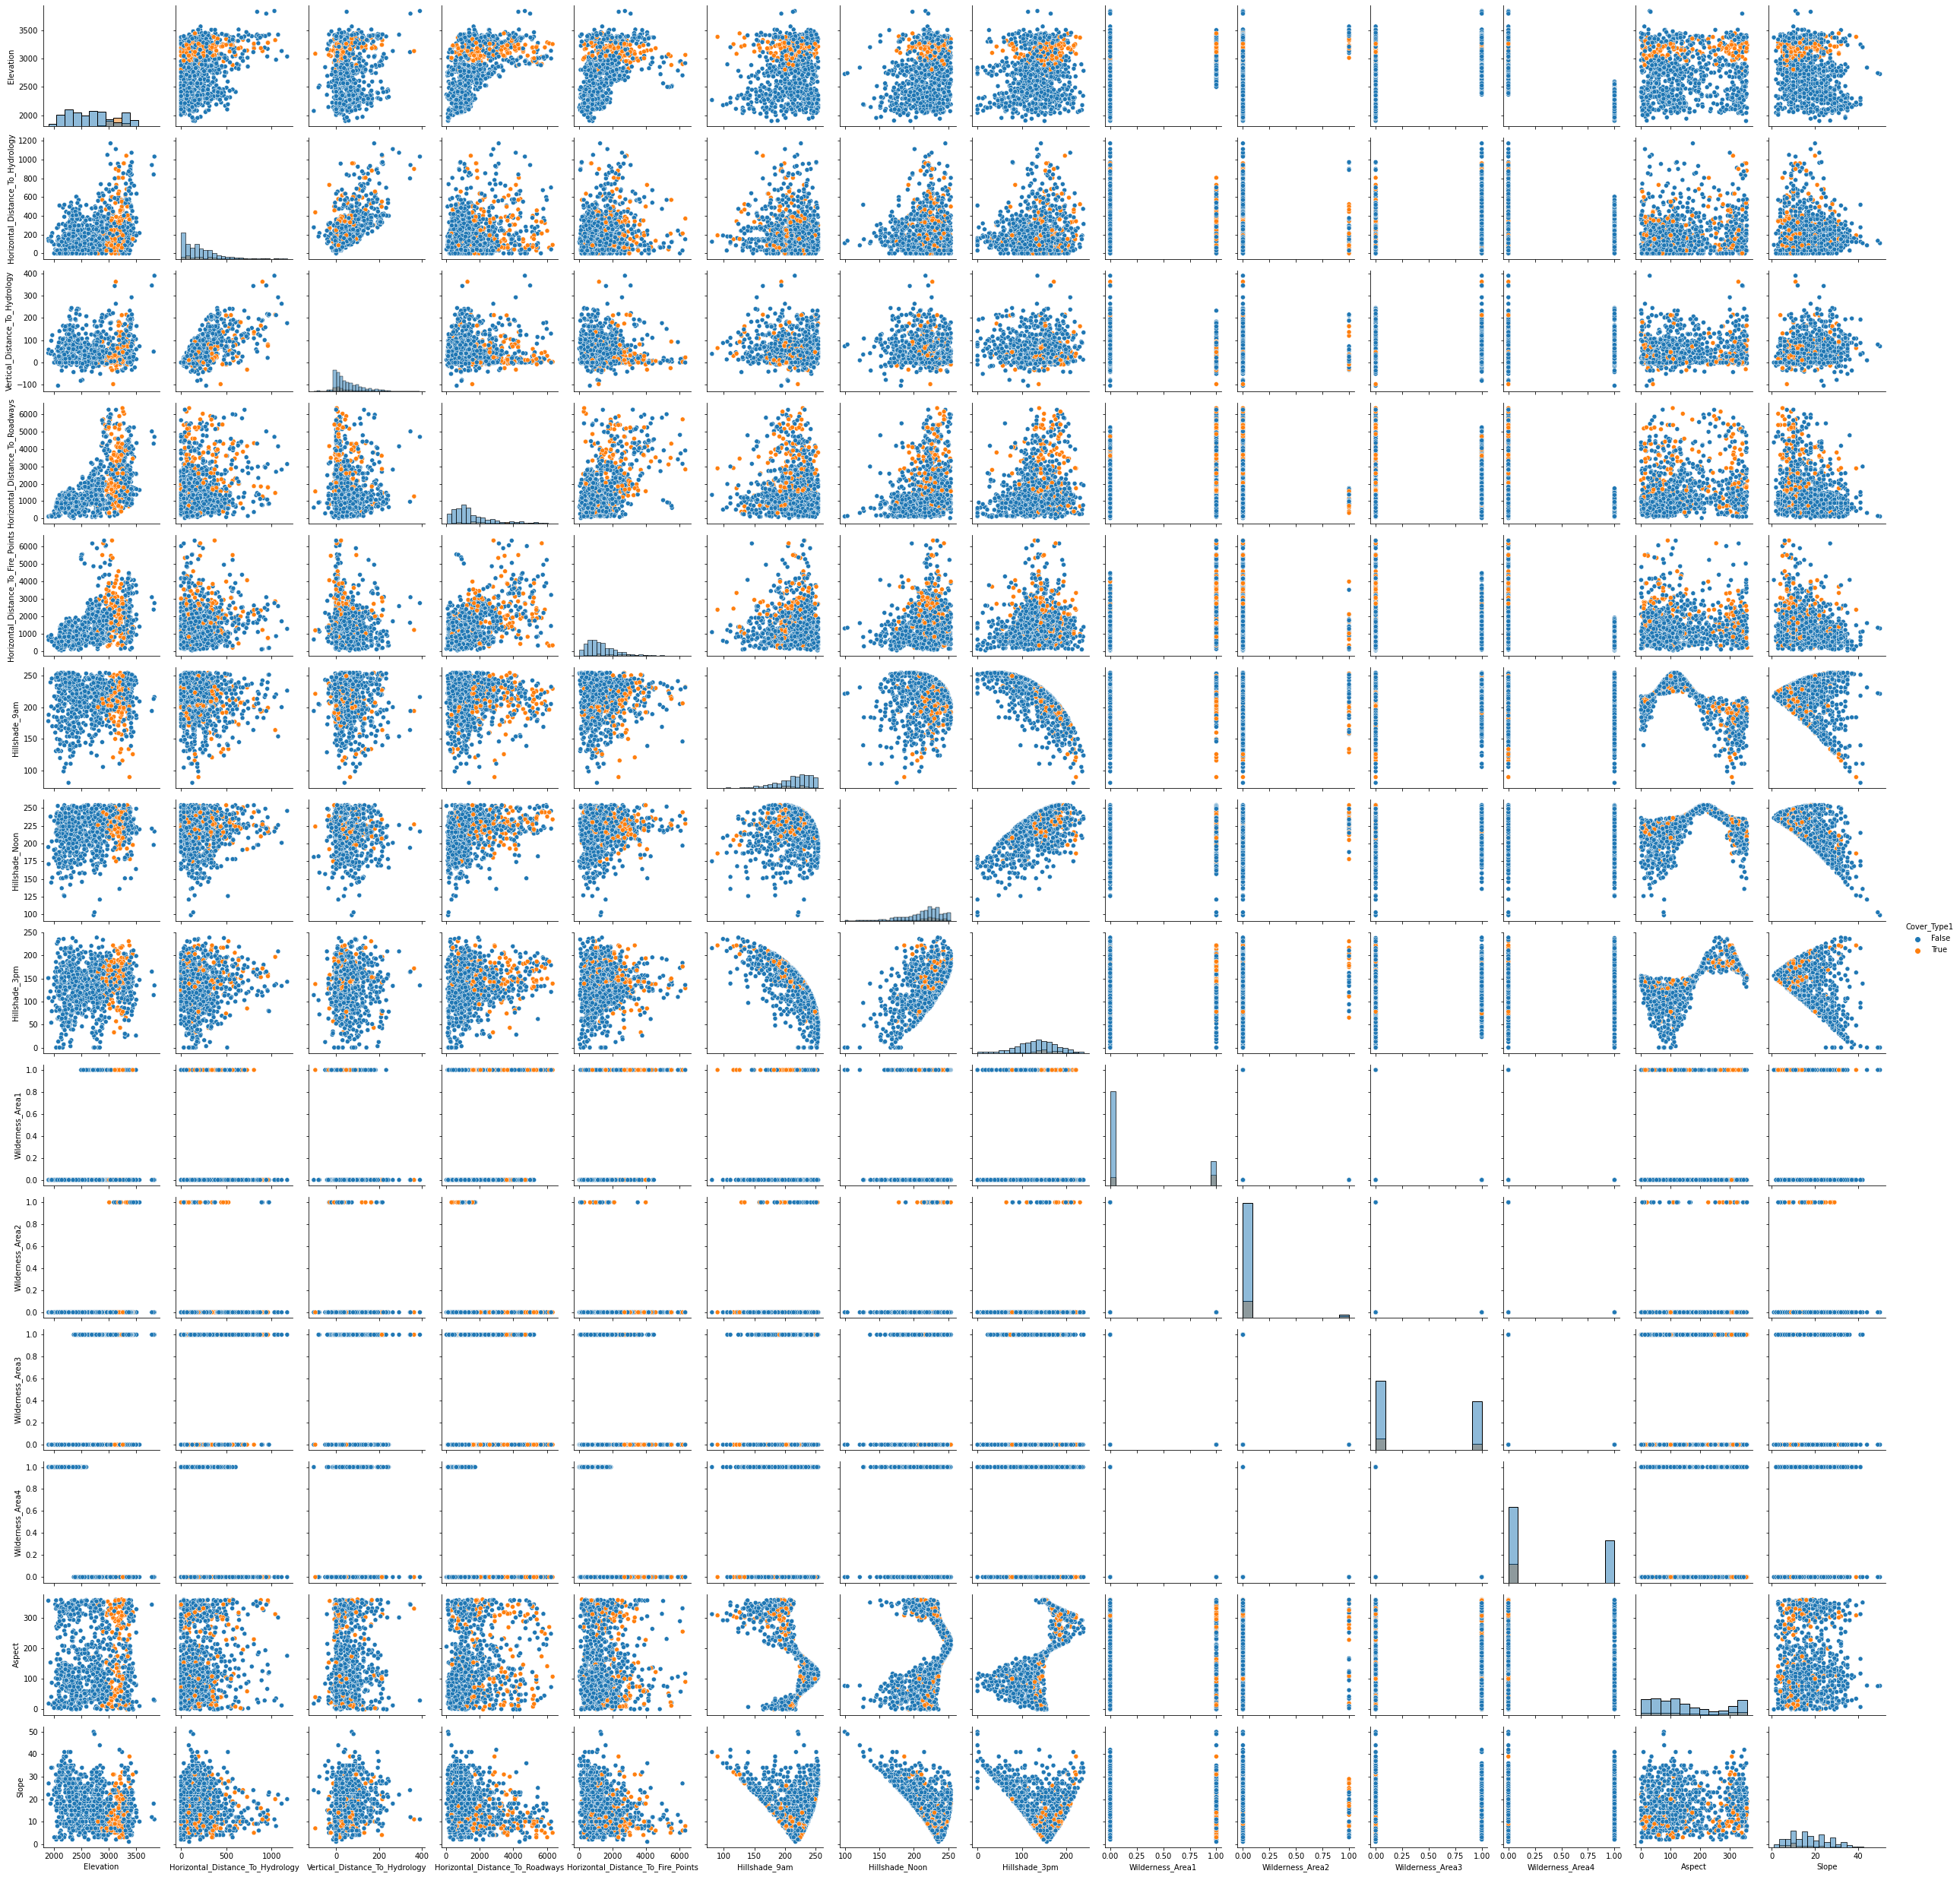

In [90]:
# g = sns.PairGrid(lin_viz,hue="Cover_Type1")
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()

## Modeling

In [93]:
# Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
